In [1]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

# Description

In this notebook, we will try to implement the architecture detailed in [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf). 

The idea is that we have a corpus of documents $C = {p_1, p_2, \dots, p_M}$ where each passage $p_i$ can be viewed as a sequence of tokens $w_1^{(i)}, w_2^{(i)}, \dots, w_{|p_i|}^{(i)}$ and given a question $q$ we want to find the sequence of tokens $w_s^{(i)}, w_{s+1}^{(i)}, \dots, w_{e}^{(i)}$ from one of the passage $i$ that can answer the question.

In order to find the passage $i$ we need an efficient **Retriever** (i.e. a function $R: (q, C) \rightarrow C_F$ where $C_F$ is a very small set of $k$ documents that have a high correlation with the query.)

In the Tf-Idf example, the retriever was simply a function that returned the top score obtained by computing the vector cosine similarity between the query and all other documents. The problem with this approach is that it is not very efficient. Tf-Idf is a **sparse** document/query representation, thus computing a multitude of dot products between these very long vectors can be expensive.

The paper cited above proposes a **dense** representation instead. It uses a Dense Encoder $E_P$ which maps all paragraphs to $d$-dimensional vectors. These vectors are stored in a database so that they can be efficiently retrieved. 

At run-time, another Dense Encoder is used $E_Q$ which maps the input question to a vector with the same dimensionality $d$. Then, a similarity score is computed between the two representations:

$sim(p,q) = E_Q(q)^\intercal E_P(p)$

In the paper, $E_Q$ and $E_P$ are two independent BERT transformers and the $d$-dimensional vector is the **output at the $\texttt{[CLS]}$ token** (so, $d = 768$).
- This leaves open the possibility to use a larger dimensionality (eg. concatenating the output at multiple blocks like we did for the QA task).

The $d$-dimensional representations of the $M$ passages are indexed using [FAISS](https://github.com/facebookresearch/faiss), an efficient, open-source library for similarity search and clustering of dense vectors developed at Facebook AI. At run-time, we simply compute $v_q = E_Q(q)$ and retrieve the top $k$ passages with embeddings closest to $v_q$.

In this case, training the network means solving a **metric learning** problem: the two BERT networks need to learn an **effective vector space** such that relevant pairs of questions and passages are close, while irrelevant pairs are placed further away. In this problem we usually build a **training instance $D$** as ${(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-)}^m_{i=1}$, where question $q$ is paired with a relevant (positive) passage $p_i^+$ and $n$ irrelevant (negative) passages. Then, the loss function is the negative log-likelihood of the positive passage:

$L(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-) = -\log\frac{e^{sim(q_i, p_i^+)}}{e^{sim(q_i, p_i^+)} + \sum_{j=1}^n e^{sim(q_i, p_{i,j}^-)}}$

It's easy to find the positive paragraph, but choosing the negatives is quite important. In particular, the paper proposes different ways for sampling the negatives:
- Random: a negative is any random passage in the corpus
- TF-IDF (The paper uses a variant, BM25): the negatives are the top passages (not containing the answer) returned by a TF-IDF search
- Gold: the negatives are positives for other questions in the mini-batch. For the researchers, this is the best negative-mining option, because it's the most efficient and also it makes a batch a complete unit of learning (we learn the relationship that each question in the batch has with the other paragraphs).

The Gold method allows the **in-batch negatives** technique: assuming to have a batch size of $B$, then we collect two $B \times d$ matrices (one for questions, one for their positive paragraphs). Then, we compute $S = QP^\intercal$ which is a $B \times B$ matrix of **similarity scored** between each question and paragraph. This matrix can directly be used for training: any ($q_i, p_j$) pais where $i = j$ is considered to be a positive example, while it's negative otherwise. In total there will be $B$ training instances per batch, each with $B-1$ negative passages. 

# Configuration

## Imports

In [2]:
import os
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union, Dict, Tuple
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
import utils

RANDOM_SEED = 42
BATCH_SIZE = 4 if not using_TPU else 64
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### TPU check
The training could be made faster if we use the cloud GPUs offered by Google on Google Colab. Since TPUs require manual intialization and other oddities, we check multiple times throughout the notebook what kind of hardware we are running the code on.
using_TPU = True


In [3]:
if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/My Drive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/My Drive/Uni/Magistrale/NLP/Project/datasets/dpr/'
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("data", "training_dpr")
    datasets_dir = os.path.join("data", "training_dpr", "dataset")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

## Allowed operations

In [5]:
OVERWRITE_DATASETS = True      # Best to be run on GPU, takes about half an hour.
                                # It saves a new copy of the pre-tokenized
                                # question-paragraph pair on Google Drive.
                                # The copy should then be uploaded to GCloud into
                                # the bucket allocated for the project to be used by
                                # TPUs.

ANALYSE_TOKENIZATIONS = True    # Tokenises all paragraphs and showcases a simple analysis
                                # for reducing the length of the sequence. Runs in less 
                                # than a few minutes on any architecture.

DO_TRAINING = True              # Best to be run on TPU, takes about 2 hours.
                                # It trains the model and saves a copy of the initial
                                # and last weights on Google Drive. When run on GPU
                                # It also saves checkpoints and Tensorboard data,
                                # but it takes over 4 hours to do a single epoch,
                                # so it's impossible to run it on Colab.

OVERRIDE_REPRESENTATIONS = True  # Best to be run on GPU, it takes about 30 minutes.
                                 # It produces representations of all paragraphs
                                 # using the trained model_p as a large NumPy array
                                 # that is stored on Google Drive at the end.

RUN_ACCURACY_ANALYSIS = True    # Best to be run on GPU, takes about an hour
                                # It analyzes the paragraph retrieval capability
                                # of the model with top-1 and top-5 accuracy.

## Variables

We define all the paths.

In [6]:
ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')
TEST_FILE = os.path.join(ROOT_PATH, 'data', 'dev_set.json')

We collect the training and validation questions into different lists. Paragraphs are collected together into a single, unified pool.

In [7]:
train_dict = utils.read_question_set(TRAINING_FILE)
test_dict = utils.read_question_set(TEST_FILE)

# Important note: the test set contains the same paragraphs as the train set,
# but different questions.

full_dict = {'data': train_dict['data'] + val_dict['data']}

def get_questions_and_paragraphs_from_dataset(dataset, offset_context=0, offset_index_q=0):
    questions = [{
            'qas': qas,
            'context_id': (i+offset_context,j)    # We also track the question's original context and paragraph indices so to have a ground truth
        }
        for i in range(len(dataset['data']))
        for j, para in enumerate(dataset['data'][i]['paragraphs'])
        for qas in para['qas']
    ]

    paragraphs = [{
            'context': para['context'],
            'context_id': (i+offset_context,j)
        }
        for i in range(len(dataset['data']))
        for j, para in enumerate(dataset['data'][i]['paragraphs'])
    ]

    for i in range(len(questions)):
        questions[i]['global_id'] = i+offset_index_q

    return questions, paragraphs

def make_paragraph_pool(train_p, val_p):
    paragraphs = train_p + val_p
    for i in range(len(paragraphs)):
        paragraphs[i]['global_id'] = i
    for i in range(len(train_p)):
        paragraphs[i]['from_set'] = 'train' 
    for i in range(len(train_p), len(train_p) + len(val_p)):
        paragraphs[i]['from_set'] = 'val' 
    return paragraphs

train_questions, train_paragraphs = get_questions_and_paragraphs_from_dataset(train_dict)
val_questions, val_paragraphs = get_questions_and_paragraphs_from_dataset(val_dict, 
                                                                          offset_context=len(train_dict['data']), 
                                                                          offset_index_q=len(train_questions))
paragraphs = make_paragraph_pool(train_paragraphs, val_paragraphs)

We create the two different DistilBert models for encoding and test them on a random question/paragraph.

In [8]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model_q, model_p = TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                   TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

What is the ideal maximum length of a sequence of tokens?

In [9]:
if ANALYSE_TOKENIZATIONS:
    lens = []
    for paragraph in tqdm(paragraphs):
        emb = tokenizer_distilbert(paragraph['context'], return_tensors='np')
        tokens = emb['attention_mask'].shape[1]
        lens.append(tokens)
    print(f"Total n. of paragraphs: {len(paragraphs)}")
    for i in range(350, 500, 10):
        print(f"Only {np.sum(np.asarray(lens) > i)} are truncated when using {i} max tokens ({np.sum(np.asarray(lens) > i) / len(paragraphs)*100}%)")

100%|██████████████████████████████████████████████████████████████████████████| 18896/18896 [00:07<00:00, 2534.29it/s]


Total n. of paragraphs: 18896
Only 245 are truncated when using 350 max tokens (1.2965707027942421%)
Only 210 are truncated when using 360 max tokens (1.111346316680779%)
Only 180 are truncated when using 370 max tokens (0.9525825571549535%)
Only 160 are truncated when using 380 max tokens (0.8467400508044031%)
Only 135 are truncated when using 390 max tokens (0.714436917866215%)
Only 114 are truncated when using 400 max tokens (0.6033022861981372%)
Only 94 are truncated when using 410 max tokens (0.49745977984758677%)
Only 81 are truncated when using 420 max tokens (0.428662150719729%)
Only 66 are truncated when using 430 max tokens (0.34928027095681624%)
Only 57 are truncated when using 440 max tokens (0.3016511430990686%)
Only 49 are truncated when using 450 max tokens (0.25931414055884844%)
Only 41 are truncated when using 460 max tokens (0.21697713801862828%)
Only 35 are truncated when using 470 max tokens (0.18522438611346317%)
Only 32 are truncated when using 480 max tokens (0.1

We can choose to truncate sequences at 380 tokens to reduce memory consumption.

Furthermore, we reduce the dimensionality of DistilBert's output to `BERT_DIMENSIONALITY` (instead of the default of 768).

In [10]:
class ReducedDistilBertModel(keras.Model):
    def __init__(self, distilbert_model):
        super(ReducedDistilBertModel, self).__init__()
        self.distilbert_model = distilbert_model
        self.reduction_layer = keras.layers.Dense(BERT_DIMENSIONALITY, 
                                                  activation='gelu')

    def call(self, inputs):
        hidden_state = self.distilbert_model(inputs).last_hidden_state
        # We introduce a dense layer that simply reduces the dimensionality of distilbert
        return self.reduction_layer(hidden_state)

model_q = ReducedDistilBertModel(model_q)
model_p = ReducedDistilBertModel(model_p)

In [11]:
test_question = train_questions[0]['qas']['question']
print(f"Testing on a simple question. \nQuestion: {test_question}")
inputs_test = tokenizer_distilbert(test_question, return_tensors="tf")
outputs = model_q(inputs_test)

# As a representation of the token we use the last hidden state at the [CLS] token (the first one)
test_q_repr = outputs[0,0,:]
print(f"Representation dimensionality: {test_q_repr.shape}")

Testing on a simple question. 
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Representation dimensionality: (768,)


# Encoders Training

First of all, we need to train our models. To do that, we need to create a dataset that feeds batches of questions and positive and negative paragraphs to a model, which is used to compute the representations, then the similarities and to correct the learnt distributions from the encoder models.

## Dataset creation

For the dataset, we use the `tf.data.Dataset` API. In particular, we first create the dataset in a `.proto` file which contains all the information in a byte format. The file is then uploaded on Google Cloud, where it can easily be accessed all future times. This is the only working way to have a large dataset accessible from the TPU.

In [12]:
def get_paragraph_from_question(qas, dataset):
    i,j = qas['context_id']
    return dataset['data'][i]['paragraphs'][j]

def get_paragraph_global_id_from_question(question, paragraphs):
    for p in paragraphs:
        if p['context_id'] == question['context_id']:
            return p['global_id']

def pre_tokenize_data(questions, dataset, tokenizer):
    tokenized_questions = [
        dict(tokenizer(questions[i]['qas']['question'], 
            max_length = MAX_SEQ_LEN, truncation = True, 
            padding = 'max_length'))
    for i in tqdm(range(len(questions)))]
    tokenized_paragraphs = [
        dict(tokenizer(get_paragraph_from_question(
                    questions[i], dataset
                )['context'], max_length = MAX_SEQ_LEN, 
            truncation = True, padding = 'max_length',
            return_offsets_mapping = True))
    for i in tqdm(range(len(questions)))]
    return tokenized_questions, tokenized_paragraphs

def find_start_end_token_one_hot_encoded(
    answers: Dict, 
    offsets: List[Tuple[int]]) -> Dict:
    '''
    This function returns the starting and ending token of the answer, 
    already one hot encoded and ready for binary crossentropy.
    Inputs:
        - answers: `List[Dict]` --> for each question, a list of answers.
            Each answer contains:
            - `answer_start`: the index of the starting character
            - `text`: the text of the answer, that we exploit through the 
                number of chars that it contains
        - offsets: `List[Tuple[int]]` --> the tokenizer from HuggingFace 
            transforms the paragraph into a sequence of tokens. 
            Offsets keeps track of the character start and end indexes for each token.
   
    Output:
        - result: `Dict` --> each key contains only one array, the one-hot 
            encoded version of, respectively, the start and end token of 
            the answer in the sentence (question+context)
    '''
    result = {
        "out_S": np.zeros(len(offsets), dtype=np.int32),
        "out_E": np.zeros(len(offsets), dtype=np.int32)
    } 
    for answer in answers:
        starting_char = answer['answer_start']
        answer_len = len(answer['text'])
        # We skip the first token, [CLS], that has (0,0) as a tuple
        for i in range(1, len(offsets)):
            # Check if starting char is within the indexes
            if (starting_char >= offsets[i][0]) and \
                (starting_char <= offsets[i][1]):
                result["out_S"][i] += 1
            # If the ending char (starting + length -1) is in the interval, 
            # same as above.
            if (starting_char + answer_len - 1 >= offsets[i][0]) and \
                (starting_char + answer_len - 1 < offsets[i][1]):
                result["out_E"][i] += 1
                break
    return result

def decode_fn(record_bytes):
    example = tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {"question__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
       "answer__out_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "answer__out_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64)})
    return {
      "questions": {'input_ids': example['question__input_ids'],
                    'attention_mask': example['question__attention_mask'],
                    'index': example['question__index']},
      "answers":   {'out_s': example['answer__out_s'],
                    'out_e': example['answer__out_e']},
      "paragraphs":{'input_ids': example['paragraph__input_ids'],
                    'attention_mask': example['paragraph__attention_mask'],
                    'tokens_s': example['paragraph__tokens_s'],
                    'tokens_e': example['paragraph__tokens_e'],
                    'index': example['paragraph__index']}
    }

def create_dataset_from_records(questions, paragraphs, dataset, tokenizer, 
                                fn, batch_size=BATCH_SIZE, training=True):
    # Pre-tokenize and write dataset on disk
    filename = f'{fn}_v3_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    gcs_filename = f'gs://volpepe-nlp-project-squad-datasets/{fn_type}.proto'
    if OVERWRITE_DATASETS:
    #if not os.path.exists(filename) or OVERWRITE_DATASETS:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, dataset, tokenizer)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
        for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["input_ids"])),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["attention_mask"])),
                    "question__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[i])),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["input_ids"])),
                    "paragraph__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["attention_mask"])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])), 
                    "paragraph__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[get_paragraph_global_id_from_question(questions[i], paragraphs)]))
                    })).SerializeToString()
                file_writer.write(record_bytes)
        print("Upload the dataset on Google Cloud and re-run the function")
        return None
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_fn)
    dataset = dataset.cache()
    dataset = dataset.shuffle(10000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.batch(batch_size)
    return dataset

### CREATE DATASETS ###
# Valid for both TPU and GPU
dataset_train = create_dataset_from_records(train_questions, paragraphs, full_dict, tokenizer_distilbert, 
                                            os.path.join(datasets_dir, 'train'))
dataset_val = create_dataset_from_records(val_questions, paragraphs, full_dict, tokenizer_distilbert,
                                            os.path.join(datasets_dir, 'val'), training=False)

Loading train_v3_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train_v3_768.proto).
Loading val_v3_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val_v3_768.proto).


## Training pipeline

First of all, we need a layer that takes as input the dictionary containing the tokenized questions and answers and returns their compact representations.

In [13]:
class DenseEncoder(layers.Layer):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.model_q = model_q  # Dense encoder for questions
        self.model_p = model_p  # Dense encoder for paragraphs
    
    def call(self, inputs, training=False):
        qs = {
            'input_ids': inputs['questions']['input_ids'],
            'attention_mask': inputs['questions']['attention_mask']
        }
        q_repr = self.model_q(qs)[:,0,:]
        if training:
            # Input contains the questions and paragraphs encoding
            ps = {
                'input_ids': inputs['paragraphs']['input_ids'],
                'attention_mask': inputs['paragraphs']['attention_mask']
            }
            p_repr = self.model_p(ps)[:,0,:]
            return q_repr, p_repr
        else:
            return q_repr

# Small test for the layer
class TestDenseEncoderModel(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        return self.enc(inputs, training=training)

test_model = TestDenseEncoderModel(model_q, model_p)
q_repr, p_repr = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=True)
print(f"Output shape when in training mode: {q_repr.shape}, {p_repr.shape}")
q_repr_2 = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=False)
print(f"Output shape when in testing mode: {q_repr_2.shape}")
q = tokenizer_distilbert(
    train_questions[0]['qas']['question'], max_length = MAX_SEQ_LEN, 
    truncation = True, padding = 'max_length', return_tensors="tf")
q_repr_3 = test_model({'questions': q})
print(f"Output shape when dealing with a single question: {q_repr_3.shape}")

Output shape when in training mode: (4, 768), (4, 768)
Output shape when in testing mode: (4, 768)
Output shape when dealing with a single question: (1, 768)


Once we have the representations, we should compute the similarities, thus obtaining a a full mini-batch of positive-negative examples. 

In [14]:
# Create the similarity matrix
S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
S.shape

TensorShape([4, 4])

This similarity matrix has the following meaning:
- Rows represent questions.
- Each row contains the similarity that the respective question has with the 16 paragraphs (one of them is the positive one, the others are negative)

In the paper, they refer to the loss as a *minimization of the negative log-likelihood of the positive passage*: what it really means is that we need to transform similarities to probabilities and use a categorical cross-entropy loss, where labels are the row index (which is also the column index in that row for the positive passage)

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
loss(y_true=tf.range(BATCH_SIZE), y_pred=S).numpy()

2.3011715

The loss seems to be quite high for this batch. We can study it with a confusion matrix.

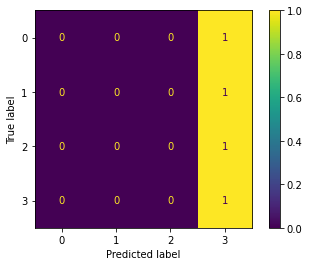

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

if not using_TPU: # Otherwise the batch size is HUGE
    S_arr = S.numpy()
    ConfusionMatrixDisplay.from_predictions(
        y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Indeed, ideally the predictions should be on the diagonal. This means that the "default" space for this metric learning problem is not that good. We are ready to learn a new representation distribution.

## Model definition

In [17]:
class DeepQPEncoder(keras.Model):

    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        if training:
            # For training we return the similarity matrix
            repr_q, repr_p = self.enc(inputs, training=training)
            S = tf.tensordot(repr_q, tf.transpose(repr_p), axes=1)
            return S
        else:
            # In other cases, we return the representation of the question(s)
            repr_q = self.enc(inputs, training=training)            
            return repr_q

    def train_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        with tf.GradientTape() as tape:
            # Obtain similarities
            S = self(x, training=True)
            # Obtain loss value
            loss = self.compiled_loss(y, S)
        # Construct gradients and apply them through the optimizer
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        S = self(x, training=True) # We are not really training, but we have to obtain S
        self.compiled_loss(y, S)
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

def create_model(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False

    model_q, model_p = ReducedDistilBertModel(model_q), ReducedDistilBertModel(model_p)

    
    print("Creating Deep Encoder...")
    model = DeepQPEncoder(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

## Training procedure

Define utility variables and saving paths.

In [18]:
EPOCHS = 100
PATIENCE = 3

Before training, we check if we're using a TPU, in order to create the model within the scope of the strategy.

Then, we train the model.

In [19]:
import datetime

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

    # Workaraound for saving locally when using cloud TPUs
    local_device_option = tf.train.CheckpointOptions(
        experimental_io_device="/job:localhost")
else:
    # GPUs and local systems don't need the above specifications. We simply
    # create a pattern for the filename and let the callbacks deal with it.
    model_name = f'model_{BERT_DIMENSIONALITY}'
    checkpoint_path = os.path.join(checkpoint_dir, model_name + "_cp-{epoch:04d}.ckpt")
    # Also, on TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        f"training_dpr_{BERT_DIMENSIONALITY}", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

Creating BERT models...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

Creating Deep Encoder...
Compiling...
Testing on some data...
Model created!


In [20]:
if DO_TRAINING:
    if not using_TPU:
        # ModelCheckpoint callback is only available when not using TPU
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_path,
            verbose=1,
            save_weights_only = True,
            save_best_only = True
        )

        # Same for tensorboard callback
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )

    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )

    callbacks = [es_callback]
    if not using_TPU:
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([cp_callback, tensorboard_callback])

    # We fit the model
    history = model.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        shuffle=True,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

    if using_TPU:
        # Save last weights
        model.save_weights(os.path.join(
            checkpoint_dir, f'training_{BERT_DIMENSIONALITY}_tpu_last.h5'), overwrite=True)
    else:
        # Final save
        model.save_weights(os.path.join(checkpoint_dir, f'final_dpr_{BERT_DIMENSIONALITY}.ckpt'), overwrite=True)

The model was trained in 7 (+3 due to patience) epochs on a local GPU. It took about 14 hours and reached a validation accuracy of 99.3%. We can make a simple test with the same data of before to see if the embedding space is working properly.

In [21]:
if DO_TRAINING:
    S = model(next(dataset_val.take(1).as_numpy_iterator()), training=True)
    S_arr = S.numpy()
    ConfusionMatrixDisplay.from_predictions(
        y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

# Question Answering with the DPR

We have trained the two Bert (`bert_p`, the paragraphs encoder and `bert_q`, the questions encoder) models to produce embeddings that are as similar as possible for matching question-paragraph pairs. 

Thanks to our training, when we use `bert_q` to encode our question, we will now be sure that questions and paragraphs will both be encoded in the same space and have a high similarity between the question encoding and the matching paragraph's encoding.

We can now use `bert_p` to encode all of our paragraphs a-priori using the same method we have used before (taking the 768-d encoding at the `[CLS]` token). These encodings will be stored in RAM. 

Then, we can define our final Question Answering model in this way:
- It receives only a question's embedding as input.
- It uses `bert_q` to create a representation of the question in the learnt 768-d space, that is in common with the paragraph representations.
- We compute similarity scores between the representation of the question and all representations of paragraphs. Based on these scores, we select the top-k ($k=100$) paragraphs.
- For each of the $k$ paragraphs, we must compute the probability of the paragraph being selected $P_{selected}(i)$, as well as the usual $P_{start, i}(s), P_{end, i}(t)$ for each of the $s$-th and $t$-th words of the $i$-th paragraph. To do that, we need the full encoding of the paragraph (the $512 \times 768$ output of Bert), which will be denoted as $P_i$ in contrast to $\hat{P}_i$ which is the 768-d encoding at the `[CLS]` token. We obtain the full encoding by passing the $k$ paragraphs through `bert_p`, which is set to non-trainable (otherwise the encoding of the `[CLS]` token would constantly change). 
- All probabilities are computed through dense layers:
\begin{gather}
P_{start,i}(s) = softmax(P_i w_{start})_s
\\
P_{end,i}(t) = softmax(P_i w_{end})_t
\\
P_{selected}(i) = softmax(\hat{P}^\intercal w_{selected})_i
\\
\end{gather}
where $w_{start}$, $w_{end}$ and $w_{selected}$ are learnt vectors, while $\hat{P} = [P_{1}^{[CLS]}, \dots, P_k^{[CLS]}]$.
- As final answer, we select the highest scoring start-end legal span from the highest-scoring paragraph.

During training: For each question, we create a batch by sampling $m$ ($m=24$ in the paper) from the top-100 passages returned by the retrieval system (DPR, so by computing similarities with the pre-computed representations). The training objective is to maximize the marginal log-likelihood of all the correct answer spans in the positive passage (the answer string may appear multiple times in one passage), combined with the log-likelihood of the positive passage being selected. In the paper, a batch size of 16 was used.


### Paragraphs representations

First of all, we load the weights of the trained model.

In [22]:
# Load the obtained weights
model.load_weights(os.path.join(checkpoint_dir, f'final_dpr_{BERT_DIMENSIONALITY}.ckpt'))

We load the encodings in memory but using the memmap mode because the files are larger than the available RAM. Basically, we are only loading a map of the file on disk in memory and for complex reads we follow this map and read from the disk.

This makes it possible to access the array, even though it will be slower than having the representations on RAM. But in this way we can also enlarge the dimensionality if needed.

In [23]:
if OVERRIDE_REPRESENTATIONS:
    # About 12 GB array
    paragraph_encodings = np.memmap(os.path.join(checkpoint_dir, f'paragraphs_encodings_{BERT_DIMENSIONALITY}.npy'),
                            dtype='float32', mode='w+', shape=(len(paragraphs), MAX_SEQ_LEN, BERT_DIMENSIONALITY))

    print("Obtaining training representations")
    for i in tqdm(range(len(paragraphs))):
        paragraph_encodings[i] = model.enc.model_p(tokenizer_distilbert(
            paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
            return_tensors='tf', truncation = True, padding = 'max_length'
        ))[0,:,:].numpy().astype(np.float32)

        if i % 200 == 0:
            # Partial save every 200 writes
            paragraph_encodings.flush()

    paragraph_encodings.flush()

In [24]:
paragraphs_encoding = np.memmap(os.path.join(checkpoint_dir, f'paragraphs_encodings_{BERT_DIMENSIONALITY}.npy'),
                            dtype='float32', mode='r', shape=(len(paragraphs), MAX_SEQ_LEN, BERT_DIMENSIONALITY))
paragraphs_encoding.shape, paragraphs_encoding.dtype

((18896, 400, 768), dtype('float32'))

### Qualitative test

We select some random questions and see whether the selected paragraph is the correct one.

In [25]:
sample_question = random.choice(val_questions)
question_text = sample_question['qas']['question']
tokenized_question = tokenizer_distilbert(question_text, return_tensors="tf")
paragraph_index = get_paragraph_global_id_from_question(sample_question, paragraphs)
print(f"Question: {question_text}")
print(f"Ground truth paragraph: {get_paragraph_from_question(sample_question, full_dict)['context']}")
print(f"Ground truth index: {paragraph_index}")
sample_q_repr = model.enc.model_q(tokenized_question)[:,0,:]
print(f"Question representation shape: {sample_q_repr.shape}")
scores = tf.tensordot(sample_q_repr, paragraphs_encoding[:,0,:].T, axes=1)
best_par_index = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
print(f"Top-5 best matching paragraphs have indexes {best_par_index}")
print(f"Top-5 best matching paragraphs:")
for i in range(5):
    print(f"{i})\t{paragraphs[best_par_index[i]]['context']}")

Question: Along with India, what other nation was to determine the how much the US would have to compensate China?
Ground truth paragraph: In the resulting Battle of Pusan Perimeter (August–September 1950), the U.S. Army withstood KPA attacks meant to capture the city at the Naktong Bulge, P'ohang-dong, and Taegu. The United States Air Force (USAF) interrupted KPA logistics with 40 daily ground support sorties that destroyed 32 bridges, halting most daytime road and rail traffic. KPA forces were forced to hide in tunnels by day and move only at night. To deny matériel to the KPA, the USAF destroyed logistics depots, petroleum refineries, and harbors, while the U.S. Navy air forces attacked transport hubs. Consequently, the over-extended KPA could not be supplied throughout the south. On 27 August, 67th Fighter Squadron aircraft mistakenly attacked facilities in Chinese territory and the Soviet Union called the UN Security Council's attention to China's complaint about the incident. The

Usually, the correct paragraphs show up in the Top-5 list.

### Quantitative test

We can measure the top-1/top-5 accuracy as we've done for the tf-idf baseline.

In [26]:
count_top1 = 0
count_top5 = 0
count_total = len(val_questions)

if RUN_ACCURACY_ANALYSIS:
    def top_5_for_question(tok_q):
        # Input: a tokenized question
        # Pass the question through the question encoder
        sample_q_repr = model.enc.model_q(tok_q)[:,0,:].numpy()
        # Compute scores with the paragraphs
        scores = np.dot(sample_q_repr, paragraphs_encoding[:,0,:].T)
        # Obtain the best scores
        top5_indices = np.argsort(scores, axis=1)[0, -5:]
        top5_scores = np.sort(scores, axis=1)[0, -5:]
        top5_para = [paragraphs[i] for i in top5_indices]
        return top5_para, top5_scores, top5_indices     

    for i,q in enumerate(tqdm(val_questions)):
        top5_para, top5_scores, top5_indices = top_5_for_question(
            tokenizer_distilbert(
                q['qas']['question'], max_length = MAX_SEQ_LEN, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            )
        )
        top5_context_ids = [top5_para[i]['global_id'] for i in range(len(top5_para))]
        gt_context_id = get_paragraph_global_id_from_question(q, paragraphs)
        if gt_context_id == top5_context_ids[0]:
            count_top1 += 1
        if gt_context_id in top5_context_ids:
            count_top5 += 1

    top1_score = count_top1 / count_total * 100
    top5_score = count_top5 / count_total * 100

    print(f"\nTop 1 score: {top1_score:.2f}%,\nTop 5 score: {top5_score:.2f}%")

Top 1 score: 16.54%

Top 5 score: 38.62%

It looks pretty bad, but these are paragraphs that were not seen in training so the model still has some generalisation capabilities. Also, the selected paragraphs are usually correlated to the question and furthermore we will analyse the first 24 paragraphs, not just the first 5, so the model still has a chance to be good at selecting the appropriate paragraph and answer.

To have a fair comparison with Tf-Idf, the same model was trained seeing all paragraphs from both training and validation and reached:

Top 1 score: 86.49%

Top 5 score: 96.58%

This is a clear improvement with respect to the Tf-Idf baseline (72.01%/87.82%), but it's also quite slower. 

## Question Answering model

We pre-tokenize the paragraphs so that we have easy access to them inside the model.

In [27]:
pretokenized_paragraphs = {
    'input_ids': [],
    'attention_mask': [],
    'offset_mapping': []
}

for i in tqdm(range(len(paragraphs))):
    token_p = dict(tokenizer_distilbert(
        paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
        return_tensors='tf', truncation = True, 
        padding = 'max_length', return_offsets_mapping = True
    ))
    pretokenized_paragraphs['input_ids'].append(token_p['input_ids'])
    pretokenized_paragraphs['attention_mask'].append(token_p['attention_mask'])
    pretokenized_paragraphs['offset_mapping'].append(token_p['offset_mapping'])

100%|██████████████████████████████████████████████████████████████████████████| 18896/18896 [00:10<00:00, 1879.18it/s]


Then, we define a function to create the model. The model should accept the top paragraphs encodings collected using the DPR and return their start, end and selection probabilities.

In [28]:
class BestScoringCollector(keras.layers.Layer):
    '''
    Custom layer to collect the start and end probabilities from the best scoring
    paragraph
    '''
    def __init__(self, **kwargs):
        super(BestScoringCollector, self).__init__(trainable=False, **kwargs)

    def call(self, probs_s, probs_e, probs_sel):
        # Selection of best scoring paragraphs
        best_scoring_paragraphs = tf.squeeze(tf.argmax(probs_sel, axis=1, output_type=tf.int32))
        # Selection of related start-end probabilities
        probs_s = tf.squeeze(tf.gather(probs_s, indices=tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
        probs_e = tf.squeeze(tf.gather(probs_e, indices=tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
        return probs_s, probs_e

def create_QA_model(m):
    # Receives in input the top paragraph full and search encodings collected using the DPR.
    paragraphs_full_encodings = keras.Input(shape=(m, MAX_SEQ_LEN, BERT_DIMENSIONALITY), 
        dtype='float32', name="topm_full_encodings")
    paragraphs_search_encodings = keras.Input(shape=(m, BERT_DIMENSIONALITY), 
        dtype='float32', name="topm_search_encodings")

    # Compute probabilities for the start token
    out_S = keras.layers.TimeDistributed(keras.layers.Dense(1), name="start_token_logits")(paragraphs_full_encodings)
    out_S = keras.layers.Reshape((m, MAX_SEQ_LEN))(out_S)
    out_S = keras.layers.Softmax(name="start_probs", axis=1, dtype='float32')(out_S)

    # The same is done for the end tokens.
    out_E = keras.layers.TimeDistributed(keras.layers.Dense(1), name="end_token_logits")(paragraphs_full_encodings)
    out_E = keras.layers.Reshape((m, MAX_SEQ_LEN))(out_E)
    out_E = keras.layers.Softmax(name="end_probs", axis=1, dtype='float32')(out_E)

    # Also, we compute paragraph selection probabilities
    out_SEL = keras.layers.Dense(1, name="selection_logits")(paragraphs_search_encodings)
    out_SEL = keras.layers.Flatten('channels_first')(out_SEL)
    out_SEL = keras.layers.Softmax(name="selection_probs", dtype='float32')(out_SEL)

    out_S, out_E = BestScoringCollector(name='best_scoring_collector')(out_S, out_E, out_SEL)

    # We return the keras model
    model = keras.Model(
        inputs=[paragraphs_full_encodings, paragraphs_search_encodings],
        outputs = [out_S, out_E, out_SEL]
    )

    return model

We analyze the model.

In [29]:
M = 24              # Number of paragraphs to be collected by the DPR (24 in the paper)

model_qa = create_QA_model(M)

In [30]:
model_qa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 topm_full_encodings (InputLaye  [(None, 24, 400, 76  0          []                               
 r)                             8)]                                                               
                                                                                                  
 topm_search_encodings (InputLa  [(None, 24, 768)]   0           []                               
 yer)                                                                                             
                                                                                                  
 start_token_logits (TimeDistri  (None, 24, 400, 1)  769         ['topm_full_encodings[0][0]']    
 buted)                                                                                       

The outputs are of the expected shape. We also use an utility to see the model visually.

In [31]:
keras.utils.plot_model(model_qa, "multi_input_and_output_model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Model input

To make things easier and allow using the `memmap` API from NumPy without loading the whole matrix of pre-encoded paragraphs in memory, we remodel the training and validation datasets so to directly produce batches that can be used for training.

In [32]:
class DensePassageRetriever():
    '''
    This object retrieves the best available passages given a question
    and a set of paragraphs (encodings). 
    It assumes that the deep question encoder (model_q) has already been
    trained.
    '''
    def __init__(self, model_q, paragraphs_encodings, m=100):
        self.model_q = model_q
        self.paragraphs_encodings = paragraphs_encodings
        self.m = m

    def __call__(self, inputs):
        '''
        Assumes that inputs is a dictionary containing (at least):
        - `input_ids`: the input ids of the questions obtained from the tokenizer
        - `attention_mask`: the attention mask of the questions obtained from the tokenizer

        Returns the (batch_size x num_parag) matrix of scores and the (batch_size x m) top_m indexes (according
        to parameter `m` which defaults to 100)
        '''
        # 1) Obtain search encoding of question
        qs = {
            'input_ids': inputs['questions']['input_ids'],
            'attention_mask': inputs['questions']['attention_mask']
        }
        q_repr = self.model_q(qs)[:,0,:].numpy()                      # batch_size x encoding_dim
        # 2) Selection of paragraphs using search encoding
        scores = np.dot(q_repr, self.paragraphs_encodings[:,0,:].T)   # batch_size x num_parag
        topm_indices = np.argsort(scores, axis=1)[:, -self.m:]        # batch_size x m
        return scores, topm_indices


In [33]:
d = DensePassageRetriever(model.enc.model_q, paragraphs_encoding)
scores, top_m_indices = d(next(dataset_train.take(1).as_numpy_iterator()))
scores.shape, top_m_indices.shape

((4, 18896), (4, 100))

The Dense Passage retriever returns indices of paragraphs, which we can collect using this function:

In [34]:
def collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, indices):
    # Collect paragraphs. Inputs is the batch of paragraph indexes to gather
    paragraphs = {
        'input_ids': tf.squeeze(tf.gather(pretokenized_paragraphs['input_ids'], indices), axis=2),
        'attention_mask': tf.squeeze(tf.gather(pretokenized_paragraphs['attention_mask'], indices), axis=2),
        'offset_mapping': tf.squeeze(tf.gather(pretokenized_paragraphs['offset_mapping'], indices), axis=2),
        'indexes': indices
    }
    # Collect paragraph representations and their search encodings
    paragraphs_full_encodings = np.take(paragraphs_encodings, indices, axis=0)
    paragraphs_search_encodings = paragraphs_full_encodings[:,:,0,:]
    return paragraphs, paragraphs_full_encodings, paragraphs_search_encodings

In [35]:
ps, full_enc, search_enc = \
    collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encoding, top_m_indices)

So we can create a dataset like this:

In [ ]:
def create_qa_dataset(questions, fn, model_q, paragraphs_encodings, pretokenized_paragraphs):
    # Instantiate DPR
    dpr = DensePassageRetriever(model_q, paragraphs_encodings)
    # Read dataset from cloud disk
    filename = f'{fn}_v3_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    gcs_filename = f'gs://volpepe-nlp-project-squad-datasets/{fn_type}.proto'
    
    if OVERWRITE_DATASETS_QA:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, full_dict, tokenizer_distilbert)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
        for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                question_ids = tok_questions[i]["input_ids"]
                question_attention_mask = tok_questions[i]["attention_mask"]
                # Create the DPR inputs
                dpr_inputs = {
                    'questions': { 
                        'input_ids': np.array(question_ids),
                        'attention_mask': np.array(question_attention_mask)
                    }
                }
                # Retrieve scores and top indices by calling the DPR
                scores, top_m_indices = dpr(dpr_inputs)
                # Obtain the paragraphs and their encodings by calling the collect function
                ps, full_enc, search_enc = \
                    collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, top_m_indices)
                
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=question_ids)),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=question_attention_mask)),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[get_paragraph_global_id_from_question(questions[i], paragraphs)])),
                    "paragraph__full_enc": tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[tf.io.serialize_tensor(np.asarray(full_enc)).numpy()])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "dpr__top_m_indices": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=list(tf.squeeze(top_m_indices)))),
                    })).SerializeToString()
                file_writer.write(record_bytes)
        print("Upload the dataset on Google Cloud and re-run the function")
        return None
    
    def decode_qa_fn(record_bytes):
        # Read example from bytes dataset
        example = tf.io.parse_single_example(
            # Data
            record_bytes,
            # Schema
            {"question__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "question__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "answer__out_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "answer__out_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "paragraph__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
            "paragraph__full_enc": tf.io.FixedLenFeature([], dtype=tf.string),
            "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "dpr__top_100_indices": tf.io.FixedLenFeature(shape=(100, ), dtype=tf.int64)
           })
        
        # Yield the final dictionary structured however we need
        return {
            'questions': {
                'input_ids': example['question__input_ids'],
                'attention_mask': example['question__attention_mask']
            },
            'answers': {
                'out_s': example['answer__out_s'],
                'out_e': example['answer__out_e']
            },
            'paragraphs': {
                'index': example['paragraph__index'],
                'full_enc': tf.io.parse_tensor(example['paragraph__full_enc'], out_type=tf.float32),
                'search_enc': tf.io.parse_tensor(example['paragraph__search_enc'], out_type=tf.float32),
                'tokens_s': example['paragraph__tokens_s'],
                'tokens_e': example['paragraph__tokens_e']
            },
            'dpr': {
                'top_100_indices': example['dpr__top_100_indices']
            }
        }
    
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_qa_fn)
    dataset = dataset.cache()
    dataset = dataset.shuffle(10000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.batch(batch_size)
    return dataset

dataset_train_qa = create_qa_dataset(train_questions, os.path.join(datasets_dir, 'train_qa'), 
                                    model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs)
dataset_val_qa = create_qa_dataset(val_questions, os.path.join(datasets_dir, 'val_qa'), 
                                  model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs)

Pre-tokenizing data...


100%|██████████████████████████████████████████████████████████████████████████| 65064/65064 [00:32<00:00, 2019.01it/s]


Preprocessing answers...


100%|█████████████████████████████████████████████████████████████████████████| 65064/65064 [00:01<00:00, 43289.41it/s]


Saving dataset on disk...


  0%|                                                                           | 54/65064 [13:57<492:30:07, 27.27s/it]

In [38]:
dataset_train_qa

<BatchDataset element_spec={'questions': {'input_ids': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'index': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, 'answers': {'out_s': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'out_e': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None)}, 'paragraphs': {'input_ids': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'tokens_s': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'tokens_e': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'index': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [36]:
def create_qa_datasets(, model_q, paragraphs_encodings, pretokenized_paragraphs):

    def qa_dataset_generator(dataset):
        # Instantiate DPR
        dpr = DensePassageRetriever(model_q, paragraphs_encodings)
        # Instantiate dataset iterator
        dataset = dataset.as_numpy_iterator()
        # Iterator over regular dataset
        for el in dataset:
            # Retrieve scores and top indices by calling the DPR
            scores, top_m_indices = dpr(el)
            # Obtain the paragraphs and their encodings by calling the collect function
            paragraphs, full_enc, search_enc = \
                collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, top_m_indices)
            # Yield the collected elements
            gt_indices = el['paragraphs']['index']
            gt_start = el['answers']['out_s']
            gt_end = el['answers']['out_e']
            yield {
                'gt_indices': gt_indices, 
                'gt_start': gt_start,
                'gt_end': gt_end,
                'top_m_indices': top_m_indices,
                'full_enc': full_enc, 
                'search_enc': search_enc
            }

    signature = {
        'gt_indices': tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.int32), 
        'gt_start': tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_LEN), dtype=tf.int32),
        'gt_end': tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_LEN), dtype=tf.int32),
        'top_m_indices': tf.TensorSpec(shape=(BATCH_SIZE, 100, ), dtype=tf.int32),
        'full_enc': tf.TensorSpec(shape=(BATCH_SIZE, 100, MAX_SEQ_LEN, BERT_DIMENSIONALITY), dtype=tf.float32), 
        'search_enc': tf.TensorSpec(shape=(BATCH_SIZE, 100, BERT_DIMENSIONALITY), dtype=tf.float32)
    }

    qa_dataset_train = tf.data.Dataset.from_generator(partial(
            qa_dataset_generator, dataset_train), 
        output_signature=signature)
    qa_dataset_val = tf.data.Dataset.from_generator(partial(
            qa_dataset_generator, dataset_val), 
        output_signature=signature)
    
    qa_dataset_train.apply(tf.data.experimental.assert_cardinality(len(dataset_train)))
    qa_dataset_val.apply(tf.data.experimental.assert_cardinality(len(dataset_val)))

    # No need to batch the dataset, it's already batched.
    qa_dataset_train = qa_dataset_train.cache()
    qa_dataset_train = qa_dataset_train.shuffle(10000)
    qa_dataset_train = qa_dataset_train.prefetch(tf.data.AUTOTUNE)
    
    qa_dataset_val = qa_dataset_val.cache()
    qa_dataset_val = qa_dataset_val.shuffle(10000)
    qa_dataset_val = qa_dataset_val.prefetch(tf.data.AUTOTUNE)

    return qa_dataset_train, qa_dataset_val

In [37]:
qa_dataset_train, qa_dataset_val = create_qa_datasets(
    dataset_train, dataset_val, model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs
)

In [38]:
next(qa_dataset_train.take(1).as_numpy_iterator())

### Training

To train the model we need to:

- Compile it defining the losses and optimizer.
- Create a ground truth batch that we use for comparing the model's output.

We define custom training and testing functions.

In [70]:
# Metrics (create under the strategy scope if using TPU)
if using_TPU:
    with strategy.scope():
        loss_tracker = keras.metrics.Mean(name="loss")
        start_acc_metric = keras.metrics.CategoricalAccuracy(name="start_token_accuracy")
        end_acc_metric = keras.metrics.CategoricalAccuracy(name="end_token_accuracy")
        sel_acc_metric = keras.metrics.CategoricalAccuracy(name="par_selection_accuracy")
else:
    loss_tracker = keras.metrics.Mean(name="loss")
    start_acc_metric = keras.metrics.CategoricalAccuracy(name="start_token_accuracy")
    end_acc_metric = keras.metrics.CategoricalAccuracy(name="end_token_accuracy")
    sel_acc_metric = keras.metrics.CategoricalAccuracy(name="par_selection_accuracy")

class QuestionAnsweringModel(keras.Model):
    def __init__(self, m=M):
        super(QuestionAnsweringModel, self).__init__()
        self.model_qa = create_QA_model(m)
    
    def call(self, inputs):
        return inputs['top_m_indices'], self.model_qa({
            'topm_full_encodings': inputs['full_enc'],
            'topm_search_encodings': inputs['search_enc']
        })

    @tf.function
    def tf_shuffle_on_columns(self, value):
        '''
        Utility function that shuffles a tensor randomly on each of its rows.
        '''
        # Create a tensor of random numbers, argsort it and use them as indices to gather
        # values from the original tensor
        return tf.gather(value, tf.argsort(tf.random.uniform(tf.shape(value))), batch_dims=1)

    @tf.function
    def obtain_training_info(self, indexes, topm_indexes):
        '''
        Obtains a batch of data and the ground truth mask to be used while training the model
        '''
        # Collect ground truth indexes
        gt_paragraphs = tf.expand_dims(tf.cast(indexes, tf.int32), -1)
        # A training sample is formed by the positive and m-1 negative examples
        # obtained from the top-100 for each of the questions in the batch.
        # We create a data batch by sampling m-1 examples from the masked 100 paragraphs
        negative_masks = tf.math.not_equal(topm_indexes, gt_paragraphs)
        # To keep the graph working with the correct sizes, we create a tensor of negatives 
        # by random shuffling the large tensor of topm and taking the first train_m elements.
        # The positive examples are replaced by randomly sampling from the same tensor.
        # It could happen that the positive example is replaced by itself, or that a 
        # negative sample appears twice in the batch, but it's a non-deterministic
        # process.
        negatives = self.tf_shuffle_on_columns(tf.where(
            negative_masks, topm_indexes, self.tf_shuffle_on_columns(topm_indexes))
        )[:,:M-1]
        # We concatenate the positive paragraph index to the selected negatives and shuffle
        # so that the positive is not always the last element
        data_batch = self.tf_shuffle_on_columns(
            tf.concat([negatives, gt_paragraphs], axis=1))
        # When we have a data batch, we create the ground truth mask, which represents the position
        # of the positive sample in the data batch in a one-hot encoded fashion.
        gt_mask = tf.cast(data_batch == gt_paragraphs, tf.int32)
        return data_batch, gt_mask

    def train_step(self, data):
        # Obtain the training batch and the ground truth mask
        data_batch, gt_mask = self.obtain_training_info(
            data['gt_indices'], data['top_m_indices'])
        # Open the gradient tape, obtain predictions and compute the loss
        with tf.GradientTape() as tape:
            _, out_S, out_E, out_SEL = self(data_batch, training=True)
            loss_start = self.compiled_loss(data['gt_start'], out_S)
            loss_end = self.compiled_loss(data['gt_end'], out_E)
            loss_sel = self.compiled_loss(gt_mask, out_SEL)
            loss_value = sum([loss_start, loss_end, loss_sel])
        # Compute the gradients and apply them on the variables
        grads = tape.gradient(loss_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the metrics
        loss_tracker.update_state(loss_value)
        start_acc_metric.update_state(data['gt_start'], out_S)
        end_acc_metric.update_state(data['gt_end'], out_E)
        sel_acc_metric.update_state(gt_mask, out_SEL)
        return {"loss": loss_tracker.result(), 
                "start_accuracy": start_acc_metric.result(),
                "end_accuracy": end_acc_metric.result(),
                "sel_accuracy": sel_acc_metric.result()}

    def test_step(self, data):
        # Obtain the training batch and the ground truth mask to compute metrics
        data_batch, gt_mask = self.obtain_training_info(
            data['gt_indices'], data['top_m_indices'])
        # Compute predictions
        _, out_S, out_E, out_SEL = self(data_batch, training=False)
        # Compute the loss to update its metric
        loss_start = self.compiled_loss(data['gt_start'], out_S)
        loss_end = self.compiled_loss(data['gt_end'], out_E)
        loss_sel = self.compiled_loss(gt_mask, out_SEL)
        loss_value = sum([loss_start, loss_end, loss_sel])
        loss_tracker.update_state(loss_value)
        # Updates the metrics
        start_acc_metric.update_state(data['gt_start'], out_S)
        end_acc_metric.update_state(data['gt_end'], out_E)
        sel_acc_metric.update_state(gt_mask, out_SEL)
        # Return a dict mapping metric names to current value.
        return {"loss": loss_tracker.result(), 
                "start_accuracy": start_acc_metric.result(),
                "end_accuracy": end_acc_metric.result(),
                "sel_accuracy": sel_acc_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        return [loss_tracker, start_acc_metric, end_acc_metric, sel_acc_metric]

def create_trainable_QA_model(model_q):
    print("Creating Question Answering model...")
    model = QuestionAnsweringModel(model_q)

    print("Compiling...")
    # Compile the model (metrics are defined into the model)
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=3e-6),
        loss = keras.losses.CategoricalCrossentropy()
    )

    print("Testing on some data...")
    # Pass one batch of test data to build the model
    inputs = next(qa_dataset_train.take(1).as_numpy_iterator())
    top_m_indices, probs_sel, probs_s, probs_e = model(inputs)
    
    print("Output shapes:")
    print(f"\tparagraphs: {top_m_indices.shape}")
    print(f"\tprobs_sel: {probs_sel.shape}")
    print(f"\tprobs_s: {probs_s.shape}")
    print(f"\tprobs_e: {probs_e.shape}")

    model.summary()

    return model

In [72]:
import datetime

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model_QA = create_trainable_QA_model(model.enc.model_q, pretokenized_paragraphs, paragraphs_encoding)

    # Workaraound for saving locally when using cloud TPUs
    local_device_option = tf.train.CheckpointOptions(
        experimental_io_device="/job:localhost")
else:
    # GPUs and local systems don't need the above specifications. We simply
    # create a pattern for the filename and let the callbacks deal with it.
    checkpoint_path = os.path.join(checkpoint_dir, "model_qa_cp-{epoch:04d}.ckpt")
    # Also, on TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        "training_qa_dpr", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model_QA = create_trainable_QA_model(model.enc.model_q, pretokenized_paragraphs, paragraphs_encoding)

Creating Question Answering model...
Compiling...
Testing on some data...


InternalError: Exception encountered when calling layer "dense_passage_retriever_2" (type DensePassageRetriever).

Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Call arguments received:
  • inputs={'questions': {'input_ids': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'index': 'tf.Tensor(shape=(4,), dtype=int64)'}, 'answers': {'out_s': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'out_e': 'tf.Tensor(shape=(4, 400), dtype=int64)'}, 'paragraphs': {'input_ids': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'tokens_s': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'tokens_e': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'index': 'tf.Tensor(shape=(4,), dtype=int64)'}}

Train the model:

In [ ]:
QA_BATCH_SIZE = 4 if not using_TPU else 32

dataset_train = create_dataset_from_records(train_questions, paragraphs, train_dict, tokenizer_distilbert, 
                                            os.path.join(datasets_dir, 'train'), batch_size=QA_BATCH_SIZE)
dataset_val = create_dataset_from_records(val_questions, paragraphs, val_dict, tokenizer_distilbert,
                                            os.path.join(datasets_dir, 'val'), training=False, batch_size=QA_BATCH_SIZE)

if DO_QA_TRAINING:
    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )
    callbacks = [es_callback]
    if not using_TPU:
        # ModelCheckpoint callback is only available when not using TPU
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_path,
            verbose=1,
            save_weights_only = True,
            save_best_only = False
        )
        # Same for tensorboard callback
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
        # Save the first weights using the pattern from before
        model_QA.save_weights(checkpoint_path.format(epoch=0))
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([cp_callback, tensorboard_callback])
    else:
        # Save first weights in a h5 file (it's the most stable way)
        model_QA.save_weights(os.path.join(
            checkpoint_dir, 'training_qa_tpu_0.h5'), overwrite=True)        

    # We fit the model
    history = model_QA.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        shuffle=True,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

    if using_TPU:
        # Save last weights
        model_qa.save_weights(os.path.join(
            checkpoint_dir, 'training_qa_tpu_last.h5'), overwrite=True)

### Obtaining an answer

In [ ]:
def start_end_token_from_probabilities(
    pstartv: np.array, 
    pendv: np.array, 
    dim:int=512) -> List[List[int]]:
    '''
    Returns a List of [StartToken, EndToken] elements computed from the batch outputs.
    '''
    idxs = []
    for i in range(pstartv.shape[0]):
        # For each element in the batch, transform the vectors into matrices
        # by repeating them dim times:
        # - Vectors of starting probabilities are stacked on the columns
        pstart = np.stack([pstartv[i,:]]*dim, axis=1)
        # - Vectors of ending probabilities are repeated on the rows
        pend = np.stack([pendv[i,:]]*dim, axis=0)
        # Once we have the two matrices, we sum them (element-wise operation)
        # to obtain the scores of each combination
        sums = pstart + pend
        # We only care about the scores in the upper triangular part of the matrix
        # (where the ending index is greater than the starting index)
        # therefore we zero out the diagonal and the lower triangular area
        sums = np.triu(sums, k=1)
        # The most probable set of tokens is the one with highest score in the
        # remaining matrix. Through argmax we obtain its position.
        val = np.argmax(sums)
        # Since the starting probabilities are repeated on the columns, each element
        # is identified by the row. Ending probabilities are instead repeated on rows,
        # so each element is identified by the column.
        row = val // dim
        col = val - dim*row
        idxs.append([row,col])
    return idxs

In [ ]:
answers_start_end = start_end_token_from_probabilities(probs_s, probs_e)
print(answers_start_end)

Finally, we can obtain the answers to the questions we have given the network.

In [ ]:
best_indices = tf.squeeze(tf.gather(paragraphs['indexes'], tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
best_offsets = tf.squeeze(tf.gather(pretokenized_val_paragraphs['offset_mapping'], best_indices))
best_offsets.shape, best_indices.shape

In [ ]:
char_start_end = [(best_offsets[i][answers_start_end[i][0]][0].numpy(),
                   best_offsets[i][answers_start_end[i][1]][1].numpy())
                 for i in range(BATCH_SIZE)]
char_start_end

In [ ]:
# Correction for answers arriving to the end of the sequence
for i in range(BATCH_SIZE):
    c = char_start_end[i]
    if c[1] >= c[0]:
        char_start_end[i] = (c[0], c[1])
    else:
        char_start_end[i] = (c[0], 1000000)

In [ ]:
for i, p in enumerate(best_indices.numpy()):
    print(val_paragraphs[p]['context'][char_start_end[i][0]:char_start_end[i][1]])

Of course, answers are extremely bad because we need to train the Dense layers selecting the start and end tokens, as well as the paragraph selector.